In [36]:
import nibabel as nb
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import adjusted_rand_score
from nilearn import plotting
from fragmenter import Fragment
from fragmenter import adjacency
from ggplot import *
from os.path import join

This is a simple analysis of the performance of the algorithms used for parcellation. This includes computing the speed of each, as well as checking the variation of the parcellations n number of times (this can be projected as an adjacency matrix where the color intensity is given by the Jaccard index--like in the corr vs comm one I did). A simple speed vs variance figure would be useful. Also add the kind of figure that Miykael has on the readme. 

In [41]:
# Set up the data
# Prep the surface and fragmentation object
surfPath = join('..','data','freesurfer','fsaverage','surf','rh.inflated')
testSurface = nb.freesurfer.read_geometry(surfPath)

# load timing and similarity data
timing = pd.read_csv('TimingData.csv')
simLbls10 = np.load('similarityLabels10.npy')
simLbls100 = np.load('similarityLabels100.npy')
methods = np.repeat(['gmm', 'k_means', 'ward'], 10)

First we have the effect of cluster size on time. These are computed on the fsaverage surface with ~160k vertices, as it denotes a 'worst case scenario' of sorts. The plot suggests that the Ward algorithm is very stable in its computation time, but it is the slowest for small parcellations. Conversely, GMM and K-means have increasing time penalties, with the former having a sharper decrease in performance. Overall, in terms on computational demands, it seems like K-means would be the best option. 

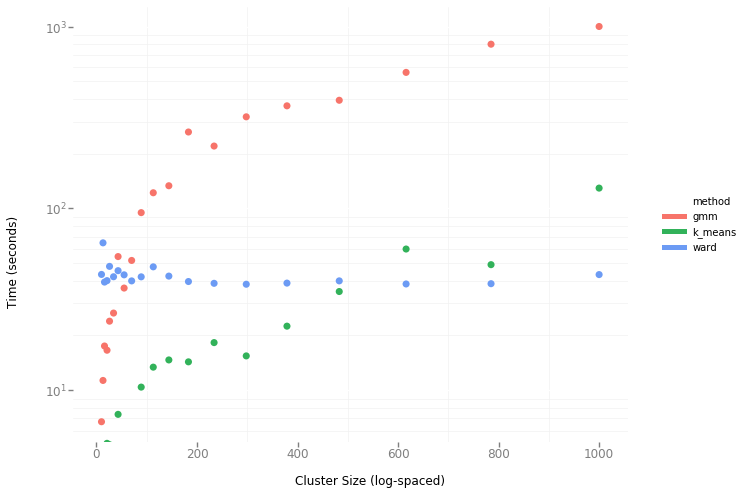

<ggplot: (-9223372036501011368)>

In [42]:
# Plot the cluster size by time data
p = ggplot(aes(x='size', y='time', color = 'method'), data=timing) +\
geom_point(size = 50) +\
scale_y_log() +\
xlab('Cluster Size (log-spaced)') +\
ylab('Time (seconds)') +\
theme_bw()
p

However, while K-means is the fastest, it is important to see how stable are the partitions produced by each algorithm. To determine this, we estimated parcels with each algorithm 10 times, and used the adjusted rand index (RI) to compute the level of agreement between any 2 parcellations across methods. The adjusted rand index estimates the rate at which every pair of nodes in partition A were equally assigned to the same/different parcels on partition B, over all possible changes (e.g. clustered together on A, but separately on B). Because of this, the adjusted rand index is a simple metric that determines the percentage agreement of any two partitions that is agnostic to the labeling scheme.

The similarity matrix below shows the rand index (with 1 being perfect agreement) for every pairwise comparison across methods. All partitions include 10 parcels.

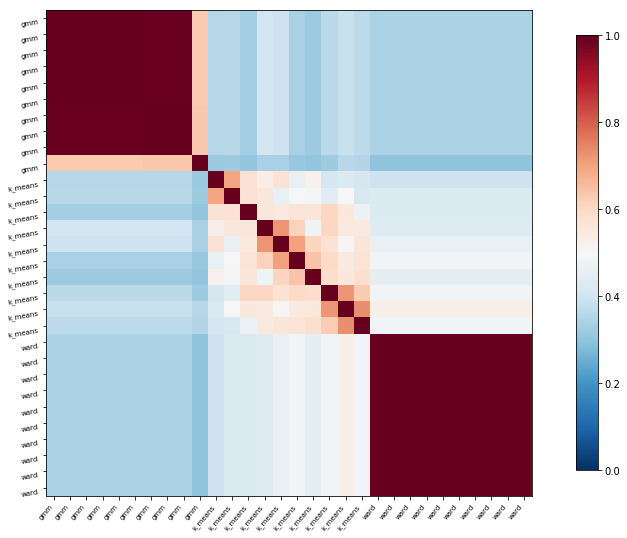

In [43]:
# Plot similarity matrix
fig = plt.figure(figsize=(10, 10))
plotting.plot_matrix(simLbls, vmin=0, reorder=True, labels=methods, figure=fig)

Overall, we can see that partitions tend to be stable within, but not across methods (most within-method RI > 0.5). Specifically, Ward is clearly perfectly stable, GMM is mostly stable (with one exception due to some small random initialization element in the algorithm), and K-means is relatively variable. If stability is a desired feature of the parcellations, then the speed of K-means might not be worth it. 

However, this was a small partition (10 parcels). The similarity matrix below shows the same approach, but estimating 100 clusters per partition.

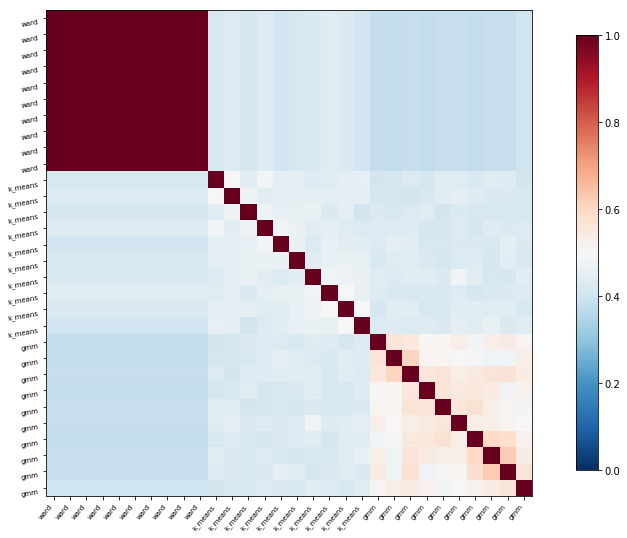

In [47]:
# Plot similarity matrix with 100 clusters
fig = plt.figure(figsize=(10, 10))
plotting.plot_matrix(simLbls100, vmin=0, vmax=1, reorder=True, labels=methods, figure=fig)

Again, we see that Ward is extremely consistent (while retaining the computing time from smaller clusterings, see fig 1). GMM, on the other hand, becomes slightly more variable. This is just to demonstrate the tradeoffs of each method, and the user will have to identify the parameter combination that best fits their needs.

One last thing to mention is the lack of spectral clustering in this data. This method relies on eigenvalue decomposition of a distance-based adjacency matrix, which for ~160k vertices is very computationally demanding. This method, however, is also very stable, and so we provide it just in case. Downsampling of the original cortical mesh to just a few vertices would be ideal to take advantage of this method.

**Code used to generate the data (timing is slow)**

In [ ]:
# # Timing
# # Set up cluster sizes (log better?)
# # clustSize = [5,50,150,300]
# clustSize = np.round(np.logspace(1,3, num=20))
# clustSize = clustSize.astype(int)
# methods = ['gmm', 'k_means', 'ward']

# tottime = []
# allLabels = []

# for cluster in clustSize:
#     print('Current cluster: ' + str(cluster))
#     testFragment = Fragment.Fragment(n_clusters=cluster)
#     for method in methods:
#         print('Current method: ' + method)
#         ST = time.time()
#         testFragment.fit(testSurface[0], testSurface[1], method = method)
#         allLabels.append(testFragment.label_)
#         tottime.append(time.time() - ST)
#
# timing = pd.DataFrame(dict(size=np.repeat(clustSize, len(methods)), 
#                            method= methods * len(clustSize),
#                           time = tottime))

In [ ]:
# # Similarity
# methods = np.repeat(['gmm', 'k_means', 'ward'], 10)
# allLabels100 = []
  
# for method in methods:
#     testFragment = Fragment.Fragment(n_clusters=100)
#     print('Current method: ' + method)
#     testFragment.fit(testSurface[0], testSurface[1], method = method)
#     allLabels100.append(testFragment.label_)
#
# simLbls100 = np.zeros((30, 30))
#
# for count, i in enumerate(allLabels100):
#     for count2, j in enumerate(allLabels100):
#         simLbls100[count,count2] = adjusted_rand_score(i,j)